<a href="https://colab.research.google.com/github/alvitohawari/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-TensorFlow/blob/main/Chapter_18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 18 — Reinforcement Learning

## 1) Summary
In this chapter, I study **Reinforcement Learning (RL)** as a framework where an agent learns by interacting with an environment:
- The agent observes a **state**, chooses an **action**, receives a **reward**, and transitions to a new state.
- The goal is to learn a **policy** that maximizes **expected cumulative return**.

What I implement and document in this notebook:
1. **MDP basics** (states, actions, rewards, transitions, discount factor).
2. **Dynamic Programming** on a small discrete environment (value iteration on FrozenLake).
3. **Model-free RL** with **Q-learning** (tabular) on FrozenLake.
4. Moving to larger state spaces:
   - why function approximation is needed,
   - the key ideas behind **Deep Q-Networks (DQN)**.
5. A compact **DQN** implementation on **CartPole** (classic control).

My workflow follows the same structure as my Chapter 2 notebook:
problem setup → baseline method → improved method → evaluation → interpretation.

In [ ]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))

TensorFlow: 2.19.0
GPU available: True


### Explanation
**What this cell does:** Imports the libraries used for Reinforcement Learning experiments (environment API, neural networks, and training utilities).

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

## 2) Reinforcement Learning concepts I keep in mind

### 2.1 Markov Decision Process (MDP)
An MDP is defined by:
- **S**: set of states
- **A**: set of actions
- **P(s' | s, a)**: transition probabilities
- **R(s, a, s')**: reward distribution (often simplified to expected reward)
- **γ**: discount factor (0 ≤ γ < 1), controls how much we value future rewards

### 2.2 Return and value functions
The discounted return from time t:
\(
G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1}
\)

Value functions:
- **Vπ(s)**: expected return starting in state s and following policy π
- **Qπ(s,a)**: expected return starting in state s, taking action a, then following π

### 2.3 Bellman equations (core idea)
Bellman expectation equation (for Vπ):
\(
V_\pi(s) = \sum_a \pi(a|s)\sum_{s'} P(s'|s,a)\left[R(s,a,s') + \gamma V_\pi(s')\right]
\)

Optimal value satisfies Bellman optimality:
\(
V^*(s)=\max_a \sum_{s'} P(s'|s,a)\left[R(s,a,s') + \gamma V^*(s')\right]
\)

### 2.4 Model-based vs model-free
- **Model-based**: we know/learn P and R and plan (e.g., value iteration).
- **Model-free**: we learn directly from experience (e.g., Q-learning).

### 2.5 Exploration vs exploitation
- exploitation: choose best-known action
- exploration: try actions to discover better outcomes
Common strategy: **ε-greedy**.

# 3) Setup: OpenAI Gym

I use classic RL benchmark environments from Gymnasium (or Gym).  
If the import fails in your Colab runtime, run the install cell below.

In [ ]:
# If Gymnasium is missing in your Colab runtime, uncomment:
# !pip -q install gymnasium[classic-control]

try:
    import gymnasium as gym
    GYMNASIUM = True
except Exception:
    import gym
    GYMNASIUM = False

print("Gymnasium:", GYMNASIUM)

Gymnasium: True


### Explanation
**What this cell does:** Imports the libraries used for Reinforcement Learning experiments (environment API, neural networks, and training utilities).

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

In [ ]:
def reset_env(env, seed=None):
    out = env.reset(seed=seed)
    if isinstance(out, tuple) and len(out) == 2:
        obs, info = out
        return obs
    return out

def step_env(env, action):
    out = env.step(action)
    if len(out) == 5:
        obs, reward, terminated, truncated, info = out
        done = terminated or truncated
        return obs, reward, done, info
    else:
        obs, reward, done, info = out
        return obs, reward, done, info

### Explanation
**Explanation:** This cell is part of the RL pipeline. It either defines a component (environment, model, policy, buffer) or runs training/evaluation steps.

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

# Part A — Dynamic Programming on a Discrete MDP (FrozenLake)

## 4) Environment: FrozenLake
FrozenLake is a small gridworld. The agent starts at a start cell and tries to reach the goal without falling into holes.

Why I use it here:
- Discrete **state space** and **action space**.
- Many implementations expose the transition model \(P(s'|s,a)\), so I can run value iteration.

In [ ]:
# is_slippery=True makes transitions stochastic (harder), False makes deterministic (easier).
env = gym.make("FrozenLake-v1", is_slippery=True)
nS = env.observation_space.n
nA = env.action_space.n
nS, nA

(np.int64(16), np.int64(4))

### Explanation
**Concept:** Creates an RL *environment* (here, CartPole). The environment defines the **state** (observation), **actions**, **rewards**, and termination conditions.

## 5) Value Iteration (planning with known model)

Value iteration updates the value estimate using Bellman optimality:
\(
V_{k+1}(s)=\max_a \sum_{s'} P(s'|s,a)\left[R(s,a,s') + \gamma V_k(s')\right]
\)

After convergence, the greedy policy w.r.t. V is approximately optimal.

In [ ]:
# Access transition model (works for classic FrozenLake)
P = env.unwrapped.P  # dict: P[s][a] -> list of (prob, next_state, reward, done)

gamma = 0.99
theta = 1e-8

V = np.zeros(nS, dtype=np.float64)

def one_step_lookahead(s, V):
    A = np.zeros(nA, dtype=np.float64)
    for a in range(nA):
        for (prob, s_next, reward, done) in P[s][a]:
            A[a] += prob * (reward + gamma * V[s_next] * (0.0 if done else 1.0))
    return A

iters = 0
while True:
    delta = 0.0
    for s in range(nS):
        A = one_step_lookahead(s, V)
        best = np.max(A)
        delta = max(delta, abs(best - V[s]))
        V[s] = best
    iters += 1
    if delta < theta:
        break

policy_vi = np.zeros(nS, dtype=np.int32)
for s in range(nS):
    policy_vi[s] = np.argmax(one_step_lookahead(s, V))

iters, V[:8], policy_vi[:8]

(324,
 array([0.54202581, 0.49880303, 0.47069551, 0.4568515 , 0.55845085,
        0.        , 0.35834799, 0.        ]),
 array([0, 3, 3, 3, 0, 0, 0, 0], dtype=int32))

### Explanation
**Explanation:** This cell is part of the RL pipeline. It either defines a component (environment, model, policy, buffer) or runs training/evaluation steps.

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

## 6) Evaluate the value-iteration policy
I run multiple episodes and measure success rate (reaching the goal).

In [ ]:
def run_policy(env, policy, n_episodes=200, seed=42):
    successes = 0
    total_rewards = []
    rng = np.random.RandomState(seed)
    for ep in range(n_episodes):
        s = reset_env(env, seed=int(rng.randint(0, 10_000)))
        done = False
        ep_reward = 0.0
        while not done:
            a = int(policy[s])
            s, r, done, _ = step_env(env, a)
            ep_reward += r
        total_rewards.append(ep_reward)
        if ep_reward > 0:
            successes += 1
    return successes / n_episodes, float(np.mean(total_rewards))

success_rate_vi, avg_reward_vi = run_policy(env, policy_vi, n_episodes=500)
success_rate_vi, avg_reward_vi

(0.704, 0.704)

### Explanation
**Explanation:** This cell is part of the RL pipeline. It either defines a component (environment, model, policy, buffer) or runs training/evaluation steps.

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

Interpretation:
- FrozenLake is stochastic when `is_slippery=True`, so even optimal policies do not succeed 100%.
- This evaluation gives me a baseline for what “good” looks like on this environment.

# Part B — Model-Free RL: Tabular Q-learning

## 7) Q-learning update rule
Q-learning learns Q*(s,a) using temporal-difference updates:

\(
Q(s,a) \leftarrow Q(s,a) + \alpha \left[r + \gamma \max_{a'}Q(s',a') - Q(s,a)\right]
\)

Key points:
- off-policy: it learns the greedy policy even if behavior policy explores.
- no need for transition model P.

In [ ]:
env_q = gym.make("FrozenLake-v1", is_slippery=True)
nS = env_q.observation_space.n
nA = env_q.action_space.n

Q = np.zeros((nS, nA), dtype=np.float64)

alpha = 0.1
gamma = 0.99

eps_start = 1.0
eps_end = 0.05
eps_decay_steps = 20_000

total_steps = 0
episodes = 8000

rewards = []
successes = 0

rng = np.random.RandomState(42)

for ep in range(episodes):
    s = reset_env(env_q, seed=int(rng.randint(0, 10_000)))
    done = False
    ep_reward = 0.0

    while not done:
        # Linear epsilon schedule
        eps = max(eps_end, eps_start - (eps_start - eps_end) * (total_steps / eps_decay_steps))

        if rng.rand() < eps:
            a = rng.randint(nA)
        else:
            a = int(np.argmax(Q[s]))

        s_next, r, done, _ = step_env(env_q, a)

        # TD target
        td_target = r + gamma * (0.0 if done else 1.0) * np.max(Q[s_next])
        Q[s, a] += alpha * (td_target - Q[s, a])

        s = s_next
        ep_reward += r
        total_steps += 1

    rewards.append(ep_reward)
    if ep_reward > 0:
        successes += 1

# learned greedy policy from Q
policy_q = np.argmax(Q, axis=1).astype(np.int32)
success_rate_q = successes / episodes

success_rate_q, np.mean(rewards[-1000:])

(0.422875, np.float64(0.534))

### Explanation
**Concept:** Creates an RL *environment* (here, CartPole). The environment defines the **state** (observation), **actions**, **rewards**, and termination conditions.

## 8) Training curve
I plot a moving average of success (reward=1 means success in FrozenLake).

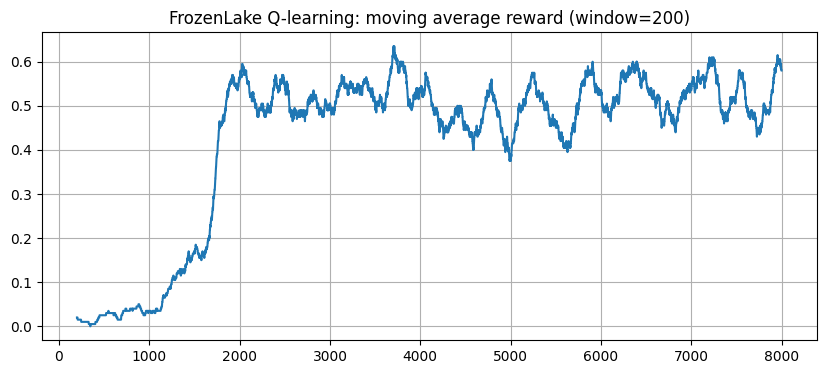

In [ ]:
window = 200
moving = pd.Series(rewards).rolling(window).mean()

plt.figure(figsize=(10, 4))
plt.plot(moving)
plt.title(f"FrozenLake Q-learning: moving average reward (window={window})")
plt.grid(True)
plt.show()

### Explanation
**Explanation:** This cell is part of the RL pipeline. It either defines a component (environment, model, policy, buffer) or runs training/evaluation steps.

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

In [ ]:
# Evaluate learned policy
env_eval = gym.make("FrozenLake-v1", is_slippery=True)
success_rate_eval, avg_reward_eval = run_policy(env_eval, policy_q, n_episodes=500)
success_rate_eval, avg_reward_eval

(0.71, 0.71)

### Explanation
**Concept:** Creates an RL *environment* (here, CartPole). The environment defines the **state** (observation), **actions**, **rewards**, and termination conditions.

Interpretation:
- If the success rate is similar to the value-iteration baseline, the tabular Q-learning is behaving correctly.
- Differences come from limited training budget and stochasticity.

# Part C — From Tabular to Deep RL: DQN on CartPole

## 9) Why DQN?
Tabular Q-learning stores Q(s,a) for every state-action pair.
That breaks when:
- state space is large or continuous (e.g., CartPole has continuous observations),
- the number of states is effectively infinite.

DQN approximates Q(s,a) using a neural network:
- input: state vector
- output: Q-values for each action

Two stabilizers commonly used:
1. **Experience Replay**: store transitions and train on random mini-batches (break correlations).
2. **Target Network**: a delayed copy of the network used to compute TD targets (reduces oscillations).

In [ ]:
env_cp = gym.make("CartPole-v1")
obs_dim = env_cp.observation_space.shape[0]
n_actions = env_cp.action_space.n
obs_dim, n_actions

(4, np.int64(2))

### Explanation
**Concept:** Creates an RL *environment* (here, CartPole). The environment defines the **state** (observation), **actions**, **rewards**, and termination conditions.

## 10) Replay Buffer + helpers
I implement a minimal replay buffer for transitions:
(s, a, r, s', done).

In [ ]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity=50_000):
        self.buffer = deque(maxlen=capacity)

    def add(self, s, a, r, s_next, done):
        self.buffer.append((s, a, r, s_next, done))

    def sample(self, batch_size):
        idx = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        batch = [self.buffer[i] for i in idx]
        s, a, r, s_next, done = map(np.array, zip(*batch))
        return s.astype(np.float32), a.astype(np.int32), r.astype(np.float32), s_next.astype(np.float32), done.astype(np.float32)

    def __len__(self):
        return len(self.buffer)

### Explanation
**Concept:** Creates an **experience replay buffer** that stores transitions \((s,a,r,s',done)\). Random sampling breaks correlations between consecutive steps and stabilizes training.

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

## 11) Q-network and target network
Architecture (simple but effective for CartPole):
Dense(64) → Dense(64) → Dense(n_actions)

Output: Q-values for each action.

In [ ]:
def build_q_network(obs_dim, n_actions):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(obs_dim,)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(n_actions)  # linear outputs (Q-values)
    ])
    return model

q_net = build_q_network(obs_dim, n_actions)
target_net = build_q_network(obs_dim, n_actions)
target_net.set_weights(q_net.get_weights())

q_net.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,610 (18.01 KB)

 Trainable params: 4,610 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

### Explanation
**Concept (DQN variant):** Uses a **target network** to compute more stable targets. The target network is periodically updated from the online network to reduce feedback-loop instability.

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

## 12) DQN training loop (compact)
Key hyperparameters:
- epsilon-greedy exploration
- discount γ
- learning rate
- target network update frequency
- replay warmup steps

In [ ]:
gamma = 0.99
lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=lr)
loss_fn = keras.losses.Huber()

buffer = ReplayBuffer(capacity=50_000)

batch_size = 64
warmup_steps = 1000
train_freq = 4
target_update_freq = 1000

eps_start = 1.0
eps_end = 0.05
eps_decay_steps = 30_000

max_episodes = 250
max_steps_per_episode = 500

global_step = 0
episode_rewards = []

def select_action(state, eps):
    if np.random.rand() < eps:
        return np.random.randint(n_actions)
    q_vals = q_net(state[np.newaxis].astype(np.float32), training=False).numpy()[0]
    return int(np.argmax(q_vals))

@tf.function
def train_step(states, actions, rewards, next_states, dones):
    # Compute target Q values
    next_q = target_net(next_states, training=False)
    max_next_q = tf.reduce_max(next_q, axis=1)
    target = rewards + (1.0 - dones) * gamma * max_next_q

    with tf.GradientTape() as tape:
        q_values = q_net(states, training=True)
        # gather Q(s,a)
        idx = tf.stack([tf.range(tf.shape(actions)[0]), actions], axis=1)
        q_sa = tf.gather_nd(q_values, idx)
        loss = loss_fn(target, q_sa)

    grads = tape.gradient(loss, q_net.trainable_variables)
    optimizer.apply_gradients(zip(grads, q_net.trainable_variables))
    return loss

### Explanation
**Concept:** Performs a **DQN training step**. It builds TD targets \(y = r + \gamma \max_{a'} Q(s',a')\) and updates network weights by minimizing the error between predicted Q-values and targets (often MSE or Huber loss).

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

In [ ]:
start_time = time.time()

for ep in range(1, max_episodes + 1):
    state = reset_env(env_cp, seed=42 + ep)
    ep_reward = 0.0

    for t in range(max_steps_per_episode):
        eps = max(eps_end, eps_start - (eps_start - eps_end) * (global_step / eps_decay_steps))
        action = select_action(state, eps)

        next_state, reward, done, _ = step_env(env_cp, action)
        buffer.add(state, action, reward, next_state, float(done))

        state = next_state
        ep_reward += reward
        global_step += 1

        # Train every few steps once buffer is warm
        if len(buffer) >= warmup_steps and (global_step % train_freq == 0):
            s_b, a_b, r_b, s2_b, d_b = buffer.sample(batch_size)
            _ = train_step(s_b, a_b, r_b, s2_b, d_b)

        # Update target network periodically
        if global_step % target_update_freq == 0:
            target_net.set_weights(q_net.get_weights())

        if done:
            break

    episode_rewards.append(ep_reward)

    if ep % 10 == 0:
        avg_last = float(np.mean(episode_rewards[-10:]))
        print(f"Episode {ep:03d} | avg_reward(last 10)={avg_last:.1f} | eps={eps:.3f} | steps={global_step}")

print("Training time:", round(time.time() - start_time, 1), "s")

Episode 010 | avg_reward(last 10)=19.7 | eps=0.994 | steps=197
Episode 020 | avg_reward(last 10)=32.5 | eps=0.984 | steps=522
Episode 030 | avg_reward(last 10)=19.7 | eps=0.977 | steps=719
Episode 040 | avg_reward(last 10)=19.3 | eps=0.971 | steps=912
Episode 050 | avg_reward(last 10)=18.1 | eps=0.965 | steps=1093
Episode 060 | avg_reward(last 10)=21.5 | eps=0.959 | steps=1308
Episode 070 | avg_reward(last 10)=20.1 | eps=0.952 | steps=1509
Episode 080 | avg_reward(last 10)=21.7 | eps=0.945 | steps=1726
Episode 090 | avg_reward(last 10)=20.5 | eps=0.939 | steps=1931
Episode 100 | avg_reward(last 10)=17.8 | eps=0.933 | steps=2109
Episode 110 | avg_reward(last 10)=25.2 | eps=0.925 | steps=2361
Episode 120 | avg_reward(last 10)=29.3 | eps=0.916 | steps=2654
Episode 130 | avg_reward(last 10)=20.1 | eps=0.910 | steps=2855
Episode 140 | avg_reward(last 10)=20.5 | eps=0.903 | steps=3060
Episode 150 | avg_reward(last 10)=24.7 | eps=0.895 | steps=3307
Episode 160 | avg_reward(last 10)=25.7 | eps

### Explanation
**Concept (DQN variant):** Uses a **target network** to compute more stable targets. The target network is periodically updated from the online network to reduce feedback-loop instability.

**Why it matters:** In RL, data is generated by the agent itself, so replay buffers, ε-greedy exploration, and stable TD targets are key to avoiding divergence and improving sample efficiency.

## 13) Plot learning curve (CartPole)
CartPole reward is the number of time steps the pole stays balanced (max is 500).

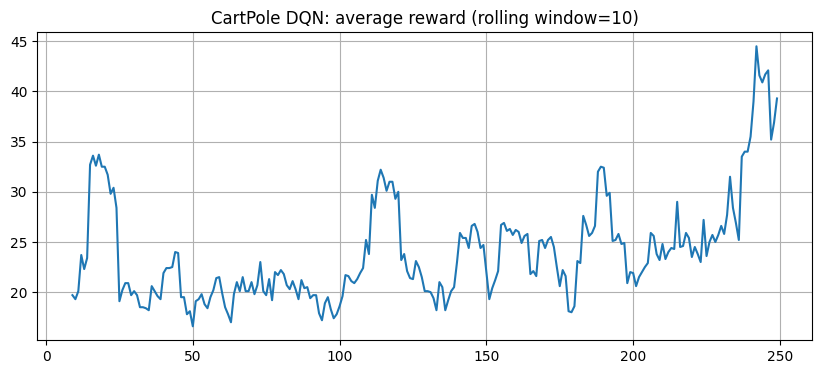

(np.float64(36.65), np.float64(111.0))

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(pd.Series(episode_rewards).rolling(10).mean())
plt.title("CartPole DQN: average reward (rolling window=10)")
plt.grid(True)
plt.show()

np.mean(episode_rewards[-20:]), np.max(episode_rewards)

### Explanation
**Concept:** Creates an RL *environment* (here, CartPole). The environment defines the **state** (observation), **actions**, **rewards**, and termination conditions.

## 14) Evaluate the trained DQN policy
I run a few episodes greedily (no exploration) and report average reward.

In [ ]:
def evaluate_dqn(env, q_net, n_episodes=10, seed=123):
    rewards = []
    rng = np.random.RandomState(seed)
    for ep in range(n_episodes):
        s = reset_env(env, seed=int(rng.randint(0, 10_000)))
        done = False
        ep_reward = 0.0
        while not done:
            q_vals = q_net(s[np.newaxis].astype(np.float32), training=False).numpy()[0]
            a = int(np.argmax(q_vals))
            s, r, done, _ = step_env(env, a)
            ep_reward += r
        rewards.append(ep_reward)
    return float(np.mean(rewards)), float(np.std(rewards))

env_eval = gym.make("CartPole-v1")
mean_r, std_r = evaluate_dqn(env_eval, q_net, n_episodes=20)
mean_r, std_r

(110.9, 20.427677303110112)

### Explanation
**Concept:** Creates an RL *environment* (here, CartPole). The environment defines the **state** (observation), **actions**, **rewards**, and termination conditions.

## 15) Optional: render one episode (if supported)
Depending on your Colab settings and gymnasium version, rendering may or may not be available.
This cell tries to render with RGB frames and display them as an animation-like sequence.

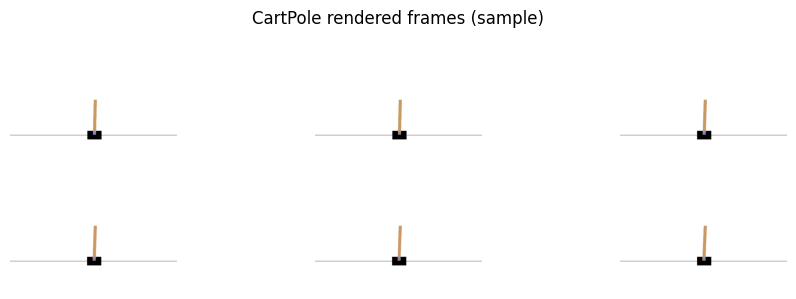

In [ ]:
# Optional render attempt (may not work in all environments)
try:
    env_r = gym.make("CartPole-v1", render_mode="rgb_array")
    s = reset_env(env_r, seed=999)
    frames = []
    done = False
    while not done:
        frames.append(env_r.render())
        q_vals = q_net(s[np.newaxis].astype(np.float32), training=False).numpy()[0]
        a = int(np.argmax(q_vals))
        s, r, done, _ = step_env(env_r, a)

    # show a few frames
    plt.figure(figsize=(10, 3))
    for i in range(min(6, len(frames))):
        plt.subplot(2, 3, i+1)
        plt.imshow(frames[i])
        plt.axis("off")
    plt.suptitle("CartPole rendered frames (sample)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Render not available in this runtime:", e)

### Explanation
**Concept:** Creates an RL *environment* (here, CartPole). The environment defines the **state** (observation), **actions**, **rewards**, and termination conditions.

## 16) Takeaways
- RL is defined by interaction: state → action → reward → next state.
- In small discrete MDPs, **planning** methods like value iteration can compute strong policies from the transition model.
- In model-free settings, **Q-learning** can learn from experience without knowing P(s'|s,a).
- For large/continuous states, we need function approximation:
  - DQN replaces the Q-table with a neural network.
  - replay buffer and target network make training more stable.
- Evaluation in RL is noisy; I rely on averages over multiple episodes and learning curves.

